<img src="mbit_logo.png" alt="drawing" align="right" style="float" width="150" height="150"/>

<font color="#D31525"><h3 align="left">Detección de fraude en transacciones financieras</h3></font>
<font color="#2C3E50"><h3 align="left"> RED NEURONAL + REDUCCIÓN DE ATRIBUTOS + UNDERSAMPLING </h3></font>

## Importar librerias
En esta primera parte del código, se realizan las llamadas a las librerías que se utilizarán en el Notebook:

In [3]:
# Paquetes de manipulación de datos
import pandas as pd
import numpy as np
import boto3

# Paquetes de visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Paquetes para normalizar los resultados
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline      import make_pipeline

# Paquetes para aplicar el modelo: Red neuronal
from sklearn.model_selection import GridSearchCV           # grid de parámetros definido
from sklearn.model_selection import RandomizedSearchCV     # grid de parámetros aleatorios sobre una determinada
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

## Importar DataSets
Importamos los datasets Train-Test y Evaluación para los que se ha aplicado PCA y submuestreo para ajustar la distribución de la clase mayoritaria.

In [4]:
s3 = boto3.client("s3")

# Seleccionamos el bucket con el que vamos a trabajar
BUCKET_NAME = 'tfmfraud'

## TrainTest

In [5]:
# Descargamos el fichero del bucket de s3 a la máquina EC2 para poder trabajar con él.
s3.download_file(Bucket = BUCKET_NAME, Key = 'train_test_under_dis.csv',Filename = '/tmp/train_test_under_dis.csv')

In [6]:
#Leemos el fichero y lo metemos en un dataframe.
trainTestDis = pd.read_csv('/tmp/train_test_under_dis.csv', dtype={'rank':'category'})

In [7]:
print (trainTestDis.shape)

(74130, 9)


In [8]:
trainTestDis.head()

,balanceOrig,balanceDest,newbalanceDest,amount,day,hours_day,type,newbalanceOrig,isFraud
0,181.0,0.00,0.00,181.00,1,1,TRANSFER,0.0,1.0
1,181.0,-21182.00,0.00,181.00,1,1,CASH_OUT,0.0,1.0
2,2806.0,-26202.00,0.00,2806.00,1,1,CASH_OUT,0.0,1.0
3,20128.0,5877.85,12145.85,20128.00,1,1,CASH_OUT,0.0,1.0
4,0.0,9291517.62,9291619.62,416001.33,1,1,CASH_OUT,0.0,1.0


In [9]:
pd.value_counts(trainTestDis['isFraud'])

0.0    66717
1.0     7413
Name: isFraud, dtype: int64

In [10]:
# Eliminar el fichero de la ruta tmp de la máquina EC2 para no ocupar espacio.
!rm /tmp/train_test_under_dis.csv

## Evaluacion

In [11]:
# Descargamos el fichero del bucket de s3 a la máquina EC2 para poder trabajar con él.
s3.download_file(Bucket = BUCKET_NAME, Key = 'eval_under_dis.csv',Filename = '/tmp/eval_under_dis.csv')

In [12]:
#Leemos el fichero y lo metemos en un dataframe.
evalDis = pd.read_csv('/tmp/eval_under_dis.csv', dtype={'rank':'category'})

In [13]:
print (evalDis.shape)

(80000, 9)


In [14]:
evalDis.head()

,balanceOrig,balanceDest,newbalanceDest,amount,day,hours_day,type,newbalanceOrig,isFraud
0,10000000.00,10000000.00,11727027.89,10000000.00,18,17,CASH_OUT,0.0,1.0
1,545780.70,0.00,0.00,545780.70,22,18,TRANSFER,0.0,1.0
2,2079746.13,2079746.13,2079746.13,2079746.13,31,14,CASH_OUT,0.0,1.0
3,46081.45,0.00,0.00,46081.45,5,6,TRANSFER,0.0,1.0
4,50722.16,50722.15,72551.64,50722.16,17,14,CASH_OUT,0.0,1.0


In [15]:
pd.value_counts(evalDis['isFraud'])

0.0    79200
1.0      800
Name: isFraud, dtype: int64

In [16]:
# Eliminar el fichero de la ruta tmp de la máquina EC2 para no ocupar espacio.
!rm /tmp/eval_under_dis.csv

## Red de Neuronas
En este caso, para aplicar una red neuronal, vamos a normalizar los datos para mejorar los resultados:

En primer lugar, debemos convertir a dummy la variable *type*:

In [17]:
trainTestDis = pd.get_dummies(trainTestDis, drop_first=True)
trainTestDis.head()

,balanceOrig,balanceDest,newbalanceDest,amount,day,hours_day,newbalanceOrig,isFraud,type_TRANSFER
0,181.0,0.00,0.00,181.00,1,1,0.0,1.0,1
1,181.0,-21182.00,0.00,181.00,1,1,0.0,1.0,0
2,2806.0,-26202.00,0.00,2806.00,1,1,0.0,1.0,0
3,20128.0,5877.85,12145.85,20128.00,1,1,0.0,1.0,0
4,0.0,9291517.62,9291619.62,416001.33,1,1,0.0,1.0,0


In [18]:
evalDis = pd.get_dummies(evalDis, drop_first=True)
evalDis.head()

,balanceOrig,balanceDest,newbalanceDest,amount,day,hours_day,newbalanceOrig,isFraud,type_TRANSFER
0,10000000.00,10000000.00,11727027.89,10000000.00,18,17,0.0,1.0,0
1,545780.70,0.00,0.00,545780.70,22,18,0.0,1.0,1
2,2079746.13,2079746.13,2079746.13,2079746.13,31,14,0.0,1.0,0
3,46081.45,0.00,0.00,46081.45,5,6,0.0,1.0,1
4,50722.16,50722.15,72551.64,50722.16,17,14,0.0,1.0,0


### Entrenamiento y test del modelo

In [19]:
# Para iniciar con el modelo, separamos en X las variables independientes y en Y la variable dependiente:
y = trainTestDis.loc[:, 'isFraud'].values
X = trainTestDis.drop(columns=['isFraud']).values

In [20]:
# Creamos los conjuntos de entrenamiento y test:
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

# Verificamos los tamaños de los df:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((51891, 8), (22239, 8), (51891,), (22239,))

In [21]:
# Configuramos una red de neuronas
norm =StandardScaler()
mlp=MLPClassifier(activation = 'relu', 
                  solver='adam', 
                  alpha=1e-5,
                  max_iter=500,
                  hidden_layer_sizes=(4, 1), 
                  random_state=1, 
                  verbose=True,
                 early_stopping =True)
mlpUnderRedDim=make_pipeline(norm, mlp)

In [22]:
# Ajustar el modelo
mlpUnderRedDim.fit(X_train, y_train)

Iteration 1, loss = 0.53101023
Validation score: 0.874759
Iteration 2, loss = 0.40107391
Validation score: 0.922929
Iteration 3, loss = 0.35632463
Validation score: 0.922929
Iteration 4, loss = 0.32239414
Validation score: 0.927360
Iteration 5, loss = 0.29183309
Validation score: 0.934489
Iteration 6, loss = 0.26310210
Validation score: 0.942967
Iteration 7, loss = 0.23682215
Validation score: 0.949326
Iteration 8, loss = 0.21361842
Validation score: 0.954528
Iteration 9, loss = 0.19364393
Validation score: 0.959730
Iteration 10, loss = 0.17635361
Validation score: 0.962042
Iteration 11, loss = 0.16117358
Validation score: 0.963584
Iteration 12, loss = 0.14766178
Validation score: 0.964547
Iteration 13, loss = 0.13520792
Validation score: 0.967437
Iteration 14, loss = 0.12423322
Validation score: 0.970135
Iteration 15, loss = 0.11568769
Validation score: 0.970906
Iteration 16, loss = 0.10897592
Validation score: 0.971869
Iteration 17, loss = 0.10334493
Validation score: 0.972832
Iterat

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(alpha=1e-05, early_stopping=True,
                               hidden_layer_sizes=(4, 1), max_iter=500,
                               random_state=1, verbose=True))])

In [23]:
# Realizamos la predicción sobre el conjunto de test
mlpUnderRedDim_pred=mlpUnderRedDim.predict(X_test)

print(classification_report(y_test, mlpUnderRedDim_pred))

conf=pd.DataFrame(
    confusion_matrix(y_test, mlpUnderRedDim_pred),
    columns=['Precicted No Default', 'Predicted Default'],
    index  =['True No Default'     , 'True Default'     ]
)
print(conf)

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     20012
         1.0       0.96      0.91      0.94      2227

    accuracy                           0.99     22239
   macro avg       0.97      0.96      0.96     22239
weighted avg       0.99      0.99      0.99     22239

                 Precicted No Default  Predicted Default
True No Default                 19919                 93
True Default                      190               2037


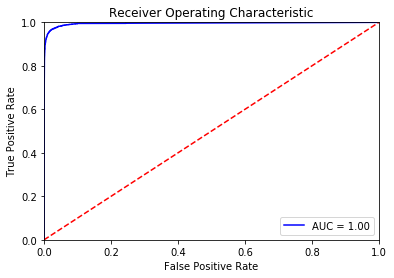

In [24]:
# Área bajo la curva ROC:  
    # Para calcular el área bajo la curva ROC (AUC) es necesario obtener
    # la probabilidad de salida del clasificador con `predict_proba`
prediccion_prob = mlpUnderRedDim.predict_proba(X_test)
#la primera columna corresponde a la etiqueta 'N'
#Es necesario convertir los True Labels a un array lógico (1 para etiqueta N)
roc_auc_score((y_test==0), prediccion_prob[:,0])

probs = mlpUnderRedDim.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Clasificación de nuevos valores 
Aplicamos el modelo al dataframe de evaluación:

In [25]:
# Para iniciar con el modelo, separamos en X las variables independientes y en Y la variable dependiente:
evaly = evalDis.loc[:, 'isFraud'].values
evalX = evalDis.drop(columns=['isFraud']).values

In [26]:
# Aplicamos el modelo
mlpUnderRedDim.score(evalX, evaly)

0.9948375

In [27]:
# Calculamos la predicción
predEval = mlpUnderRedDim.predict(evalX)

In [28]:
# Matriz de confusión
cm=confusion_matrix(evaly, predEval)
pd.DataFrame(cm, index=('0_true','1_true'), columns=('0_pred','1_pred'))

,0_pred,1_pred
0_true,78866,334
1_true,79,721


In [29]:
pru = np.where(predEval > 0.4,1,0)
print(classification_report(evaly, pru))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     79200
         1.0       0.68      0.90      0.78       800

    accuracy                           0.99     80000
   macro avg       0.84      0.95      0.89     80000
weighted avg       1.00      0.99      1.00     80000



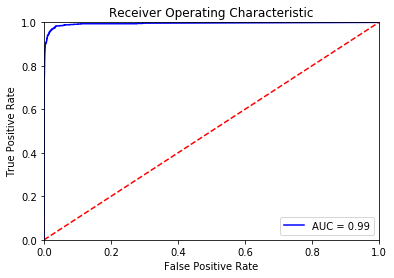

In [30]:
# Curva ROC
probs_eval = mlpUnderRedDim.predict_proba(evalX)
preds_eval = probs_eval[:,1]
fpr_eval, tpr_eval, threshold_eval = metrics.roc_curve(evaly, preds_eval)
roc_auc_eval = metrics.auc(fpr_eval, tpr_eval)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_eval, tpr_eval, 'b', label = 'AUC = %0.2f' % roc_auc_eval)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Guardamos la predicción
Guardamos la predicción realizada en el dataframe de Evaluación:

In [19]:
predNN = pd.DataFrame(predEval, columns = ["NNUnderRedDim_pred"])
modelResult = pd.concat([evalDis, predNN["NNUnderRedDim_pred"]],axis = 1)
modelResult.head()

,balanceOrig,balanceDest,newbalanceDest,amount,day,hours_day,newbalanceOrig,isFraud,type_TRANSFER,NNUnderRedDim_pred
0,447009.83,447009.83,492147.95,447009.83,13,15,0.0,1.0,0,1.0
1,5338162.80,5338162.79,5520058.37,5338162.80,15,19,0.0,1.0,0,1.0
2,537539.57,537539.56,545573.72,537539.57,31,16,0.0,1.0,0,1.0
3,148188.84,0.00,0.00,148188.84,3,15,0.0,1.0,1,1.0
4,216351.05,0.00,0.00,216351.05,5,9,0.0,1.0,1,1.0


In [20]:
pd.crosstab(index=modelResult['isFraud'],columns=modelResult['NNUnderRedDim_pred'], margins=True)

NNUnderRedDim_pred,0.0,1.0,All
isFraud,,,
0.0,78879,321,79200
1.0,76,724,800
All,78955,1045,80000
